In [3]:
!pip install torch torchvision torchaudio

  Using cached torch-2.7.1-cp311-cp311-win_amd64.whl.metadata (28 kB)
  Using cached torchvision-0.22.1-cp311-cp311-win_amd64.whl.metadata (6.1 kB)
  Using cached torchaudio-2.7.1-cp311-cp311-win_amd64.whl.metadata (6.6 kB)
  Using cached sympy-1.14.0-py3-none-any.whl.metadata (12 kB)
  Using cached networkx-3.5-py3-none-any.whl.metadata (6.3 kB)
  Using cached fsspec-2025.5.1-py3-none-any.whl.metadata (11 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
   ---------------------------------------- 0.0/216.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/216.1 MB ? eta -:--:--
   ---------------------------------------- 0.3/216.1 MB ? eta -:--:--
   ---------------------------------------- 0.5/216.1 MB 1.4 MB/s eta 0:02:34
   ---------------------------------------- 0.5/216.1 MB 1.4 MB/s eta 0:02:34
   ---------------------------------------- 0.8/216.1 MB 838.9 kB/s eta 0:04:17
   ---------------------------------------- 1.0/216.1 MB 1.0 MB/s eta 0:03

Epoch 1, Loss: 0.0252
Epoch 2, Loss: 0.0101
Epoch 3, Loss: 0.0092
Epoch 4, Loss: 0.0080
Epoch 5, Loss: 0.0077


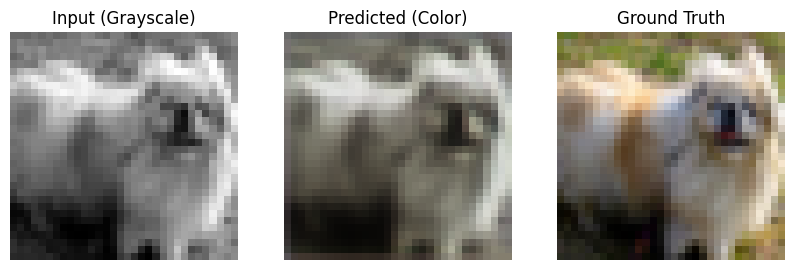

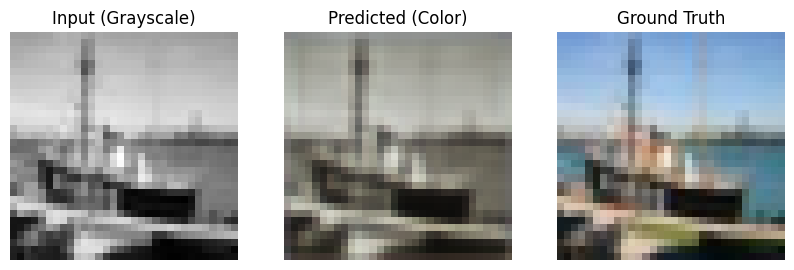

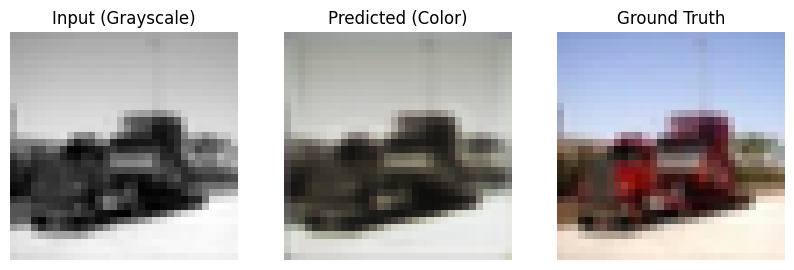

In [6]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class CIFAR10Colorization(Dataset):
    def __init__(self, max_samples=1000):
        self.dataset = torchvision.datasets.CIFAR10(
            root='./data', train=True, download=True,
            transform=T.ToTensor()
        )
        self.max_samples = max_samples
        self.to_gray = T.Grayscale()

    def __len__(self):
        return self.max_samples

    def __getitem__(self, idx):
        color_img, _ = self.dataset[idx]  # Shape: (3,32,32)
        gray_img = self.to_gray(color_img)  # Shape: (1,32,32)
        return gray_img, color_img

dataset = CIFAR10Colorization()
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

class ColorizationCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1), nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1), nn.ReLU(),
            nn.Conv2d(64, 3, kernel_size=3, padding=1), nn.Sigmoid()  # Output: RGB in [0,1]
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

model = ColorizationCNN().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(5):
    total_loss = 0
    for gray, color in dataloader:
        gray, color = gray.to(device), color.to(device)
        output = model(gray)
        loss = criterion(output, color)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss / len(dataloader):.4f}")

model.eval()
gray, color = next(iter(dataloader))
gray, color = gray.to(device), color.to(device)
with torch.no_grad():
    output = model(gray)

def show_images(gray, output, target, index=0):
    fig, axs = plt.subplots(1, 3, figsize=(10, 3))
    axs[0].imshow(gray[index][0].cpu(), cmap='gray')
    axs[0].set_title("Input (Grayscale)")
    axs[1].imshow(output[index].permute(1, 2, 0).cpu())
    axs[1].set_title("Predicted (Color)")
    axs[2].imshow(target[index].permute(1, 2, 0).cpu())
    axs[2].set_title("Ground Truth")
    for ax in axs:
        ax.axis('off')
    plt.show()

for i in range(3):
    show_images(gray, output, color, index=i)